<a href="https://colab.research.google.com/github/diefgallegorio/Entrega-MLP-housing/blob/master/HOUSING_Redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP HOUSING**

Instalo Tensorflow y keras

In [0]:
!pip install tensorflow==2.0.0-alpha0
# !pip install --upgrade tensorflow
# !pip install -U tensorflow-gpu==2.0.0 grpcio
!pip install --upgrade keras

     |████████████████████████████████| 79.9MB 53kB/s 
     |████████████████████████████████| 3.0MB 53.7MB/s 
     |████████████████████████████████| 419kB 49.7MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 378kB 3.4MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


### Importo desde Drive base de datos y archivo de funciones para el pre-procesamiento

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras

# para acceder a archivos desde google drive en google colaboratory
# acceso a google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Importo base de datos housing

housing = '1ruQwtMNWfV2zXdntUSPUsjk2fUrskhHM'
downloaded = drive.CreateFile({'id': housing})
downloaded.GetContentFile('housing.csv') 

#Importo archivo de funciones para housing

Funciones = '1TIzuOdjhgFsE3maEH88THxIWGiP8fU5t'
downloaded = drive.CreateFile({'id': Funciones})
downloaded.GetContentFile('Funciones.py') 

#Importo la función declarada en el archivo externo

from Funciones import pre_exploratorio_housing

#Con pandas leo la base de datos y pruebo que cargue adecuadamente
Xdata = pd.read_csv('housing.csv')
Xdata.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Divido el dataset en uno de test y otro de entrenamiento, este ultimo a la vez se divide en uno de validación y otro de entrenamiento

In [0]:
from sklearn.model_selection import train_test_split

XtrainCompleto, Xtest = train_test_split(Xdata, test_size=0.3)
Xtrain, Xvalid = train_test_split(XtrainCompleto, test_size=0.3)
# Xtrain.head()

### Aplico pre-procesamiento all dataset de entrenamiento y validación

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder

#Separo columna de salida, categórigas y numericas
col_sal='median_house_value'
col_num=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms',
        'population','households','median_income']
col_cat=['ocean_proximity']

#Llamo función de pre_exploratorio para completar campos nulos
Xtrain, Ytrain= pre_exploratorio_housing(Xtrain,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')

#Categorizo
codificador = OrdinalEncoder()
Xtrain['ocean_proximity'].value_counts()
Xtrain['ocean_proximity'] = codificador.fit_transform(Xtrain[['ocean_proximity']])

In [0]:
Xvalid, Yvalid= pre_exploratorio_housing(Xvalid,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')

Xvalid['ocean_proximity'].value_counts()
Xvalid['ocean_proximity'] = codificador.fit_transform(Xvalid[['ocean_proximity']])

In [0]:
print("Xtrain", Xtrain.shape)
print("Xvalid", Xvalid.shape)

Xtrain (10113, 9)
Xvalid (4335, 9)


## Creo la red densa y la preparo para entrenarla

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(200, input_shape=(9,), activation="relu"),
    keras .layers.Dense(100, activation="relu"),
    keras .layers.Dense(50, activation="sigmoid"),
    keras.layers.Dense(1)
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               2000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 27,201
Trainable params: 27,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
weights

array([[ 0.07508279, -0.0222761 , -0.11634108, ...,  0.03284629,
        -0.02379375,  0.06043784],
       [-0.11531055, -0.08247198,  0.08684605, ...,  0.08650355,
        -0.11461566,  0.02537002],
       [-0.0093829 , -0.13061117,  0.04415175, ..., -0.07067501,
         0.03312901, -0.08343501],
       ...,
       [ 0.09519777,  0.03646168,  0.07257286, ...,  0.03690544,
        -0.01276261,  0.02257803],
       [-0.0659456 , -0.07762779,  0.06294619, ...,  0.11997928,
         0.09963998, -0.09412828],
       [ 0.03827022,  0.09237555,  0.07034943, ...,  0.09009489,
         0.1337028 ,  0.10939102]], dtype=float32)

In [0]:
print(biases.shape)
biases

(100,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [0]:
model.compile(loss=keras.losses.mse,
              optimizer="sgd",
              metrics=[keras.losses.mae])

In [0]:
history = model.fit(Xtrain, Ytrain, epochs=10, validation_data=(Xvalid, Yvalid))

Train on 10113 samples, validate on 4335 samples
Epoch 1/10
10113/10113 [==============================] - 1s 100us/sample - loss: 14952371095.2002 - mean_absolute_error: 94833.0391 - val_loss: 13023412998.5550 - val_mean_absolute_error: 91134.4141
Epoch 2/10
10113/10113 [==============================] - 1s 78us/sample - loss: 13616920268.3849 - mean_absolute_error: 92450.5391 - val_loss: 13125421672.5260 - val_mean_absolute_error: 92413.8281
Epoch 3/10
10113/10113 [==============================] - 1s 80us/sample - loss: 13623584153.6810 - mean_absolute_error: 92518.4219 - val_loss: 12975168732.6265 - val_mean_absolute_error: 89194.9219
Epoch 4/10
10113/10113 [==============================] - 1s 80us/sample - loss: 13624528685.3879 - mean_absolute_error: 92270.7969 - val_loss: 12970673839.3910 - val_mean_absolute_error: 89727.7188
Epoch 5/10
10113/10113 [==============================] - 1s 77us/sample - loss: 13620319658.8945 - mean_absolute_error: 92344.8125 - val_loss: 1297201255

In [0]:
history.params

{'batch_size': 32,
 'do_validation': True,
 'epochs': 10,
 'metrics': ['loss',
  'mean_absolute_error',
  'val_loss',
  'val_mean_absolute_error'],
 'samples': 10113,
 'steps': None,
 'verbose': 0}

In [0]:
history.history

{'loss': [14952371095.200237,
  13616920268.384851,
  13623584153.681005,
  13624528685.387917,
  13620319658.894493,
  13623167672.437456,
  13622619555.736973,
  13621260734.133097,
  13622897427.30189,
  13614818262.586374],
 'mean_absolute_error': [94833.04,
  92450.54,
  92518.42,
  92270.8,
  92344.81,
  92377.96,
  92435.64,
  92454.63,
  92365.445,
  92301.734],
 'val_loss': [13023412998.555017,
  13125421672.525951,
  12975168732.626528,
  12970673839.391003,
  12972012556.991926,
  13147736499.347635,
  13043689055.549711,
  12977367417.238293,
  12970269574.348328,
  12970730126.556862],
 'val_mean_absolute_error': [91134.414,
  92413.83,
  89194.92,
  89727.72,
  89356.445,
  92642.914,
  91436.9,
  90132.4,
  89612.75,
  89476.14]}

In [0]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

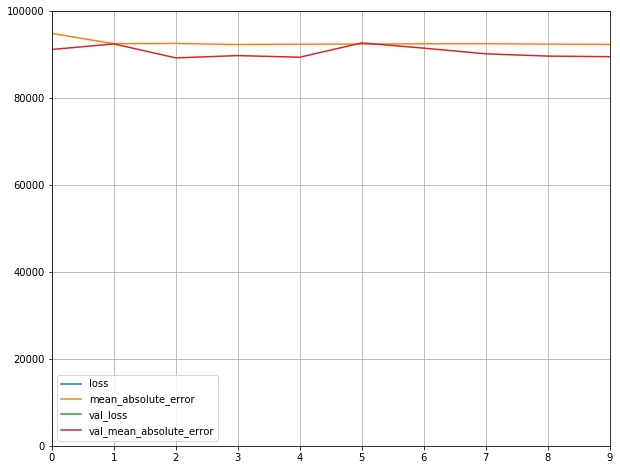

In [0]:
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 100000)
#save_fig("keras_learning_curves_plot")
plt.show()

In [0]:
Xtest, Ytest = pre_exploratorio_housing(Xtest,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')
#Categorizo
codificador = OrdinalEncoder()
Xtest['ocean_proximity'].value_counts()
Xtest['ocean_proximity'] = codificador.fit_transform(Xtest[['ocean_proximity']])

In [0]:
X_test = Xtest
y_test = Ytest

In [0]:
model.evaluate(Xtest, Ytest)

6192/6192 [==============================] - 0s 35us/sample - loss: 13082587069.8501 - mean_absolute_error: 90071.1797


[13082587069.85013, 90071.18]

In [0]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[205146.38],
       [205146.38],
       [205146.38]], dtype=float32)

In [0]:
y_pred = model.predict_classes(X_new)
y_pred

array([[1],
       [1],
       [1]], dtype=int32)

In [0]:
y_new = y_test[:3]
y_new

5921     349100.0
18108    372700.0
4698     485000.0
Name: median_house_value, dtype: float64

TypeError: ignored

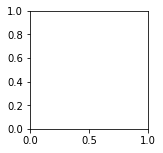

In [0]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()